In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [36]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [37]:
df = sns.load_dataset('titanic')
df.head()

,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [38]:
# Drop irrelevant columns
df = df.drop(['deck', 'embark_town', 'alive', 'class', 'who'], axis=1)

In [39]:
df.isna().sum()

survived        0
pclass          0
sex             0
age           177
sibsp           0
parch           0
fare            0
embarked        2
adult_male      0
alone           0
dtype: int64

In [40]:
df['age'] = df['age'].fillna(df['age'].median())
df['embarked'] = df['embarked'].fillna(df['embarked'].mode()[0])

In [41]:
label_enc = LabelEncoder()
for col in ['sex', 'embarked', 'alone']:
    df[col] = label_enc.fit_transform(df[col])

df.head()


,survived,pclass,sex,age,sibsp,parch,fare,embarked,adult_male,alone
0,0,3,1,22.0,1,0,7.2500,2,True,0
1,1,1,0,38.0,1,0,71.2833,0,False,0
2,1,3,0,26.0,0,0,7.9250,2,False,1
3,1,1,0,35.0,1,0,53.1000,2,False,0
4,0,3,1,35.0,0,0,8.0500,2,True,1


In [42]:
X = df.drop('survived', axis=1)
y = df['survived']

In [43]:
X_train, X_test,  y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [44]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((712, 9), (179, 9), (712,), (179,))

In [45]:
base_tree = DecisionTreeClassifier(random_state=42)

adaboost = AdaBoostClassifier(
	estimator = base_tree,
	n_estimators = 100,
 	learning_rate = 0.5,
	random_state = 42
)

In [46]:
adaboost.fit(X_train, y_train)

,estimator,DecisionTreeC...ndom_state=42)
,n_estimators,100
,learning_rate,0.5
,algorithm,'deprecated'
,random_state,42
,criterion,'gini'
,splitter,'best'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0


In [47]:
y_pred = adaboost.predict(X_test)

Accuracy Score: 0.776536312849162

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.82      0.81       105
           1       0.74      0.72      0.73        74

    accuracy                           0.78       179
   macro avg       0.77      0.77      0.77       179
weighted avg       0.78      0.78      0.78       179



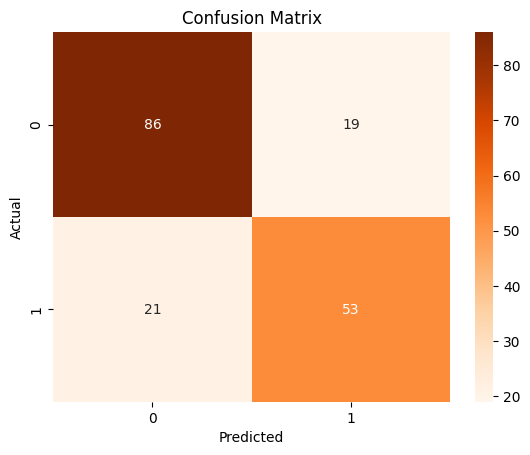

In [49]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy Score:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Oranges')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [50]:
parameters = {
	'n_estimators': [50, 100, 200],
	'estimator__max_depth': [1, 2, 3],
	'learning_rate': [0.1, 0.5, 1.0]
}


In [51]:
grid = GridSearchCV(
	estimator = adaboost,
	param_grid = parameters,
	cv = 5
)

In [52]:
grid.fit(X_train, y_train)

,estimator,AdaBoostClass...ndom_state=42)
,param_grid,"{'estimator__max_depth': [1, 2, ...], 'learning_rate': [0.1, 0.5, ...], 'n_estimators': [50, 100, ...]}"
,scoring,None
,n_jobs,None
,refit,True
,cv,5
,verbose,0
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,criterion,'gini'


In [53]:
print("best parameters : ", grid.best_params_)

best parameters :  {'estimator__max_depth': 3, 'learning_rate': 0.5, 'n_estimators': 200}


In [54]:
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

In [55]:
print("Tuned score : ", accuracy_score(y_test, y_pred))
print("classification report : \n", classification_report(y_test, y_pred))


Tuned score :  0.8324022346368715
classification report : 
               precision    recall  f1-score   support

           0       0.84      0.89      0.86       105
           1       0.82      0.76      0.79        74

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



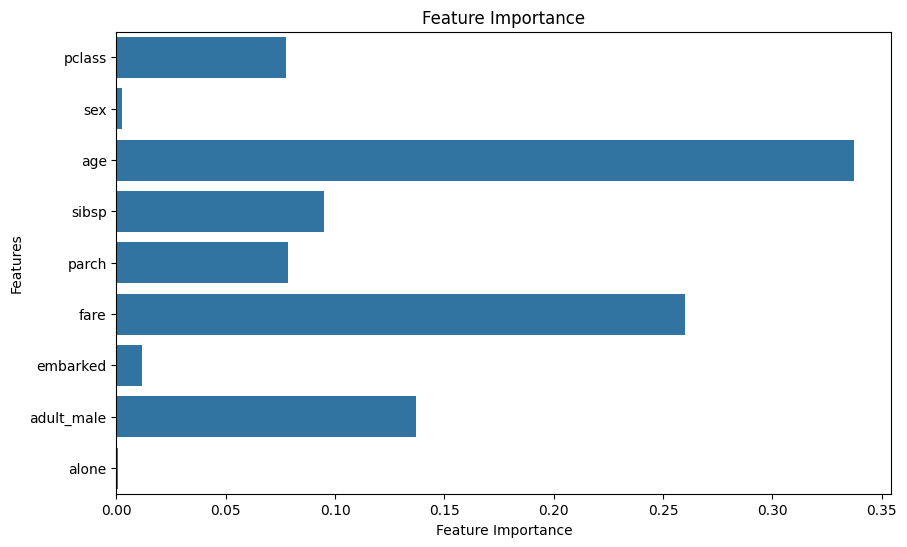

In [56]:
feature_importance = best_model.feature_importances_
features = X.columns

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_importance, y=features)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Feature Importance')
plt.show()

In [57]:
sample = pd.DataFrame([{
	'pclass': 3,
	'sex': 1,
	'age': 22,
	'sibsp': 1,
	'parch': 0,
	'fare': 7.25,
	'embarked': 2,
	'adult_male': True,
	'alone': False
}])

In [58]:
print(best_model.predict(sample)) # survived = 1, not survived = 0

[0]


In [59]:
tuned_accuracy = best_model.score(X_test, y_test)
print("First accuracy score : ",accuracy)
print("Tuned score : ", tuned_accuracy)

First accuracy score :  0.776536312849162
Tuned score :  0.8324022346368715
